In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Part 1 - Building the CNN

# Importing the Keras libraries and packages

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers.normalization import BatchNormalization

In [3]:
path_to_train = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/training_set")
path_to_test = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/test_set")
dogs_train_path = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/training_set/dogs")
cats_train_path = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/training_set/cats")
dogs_test_path = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/test_set/dogs")
cats_test_path = pathlib.Path("/kaggle/input/dogs-cats-images/dataset/test_set/cats")

# Data Visualization And Augumentation

In [4]:
image_count_train = len(list(path_to_train.glob('*/*.jpg')))
print("Total Training Images = ", image_count_train)
image_count_test = len(list(path_to_test.glob('*/*.jpg')))
print("Total Testing Images = ", image_count_test)
# The glob (short for global) module is used to return all file paths that match a specific pattern

Total Training Images =  8000
Total Testing Images =  2000


In [5]:
sample_datagen = ImageDataGenerator(rescale=1./255)
sample_data = sample_datagen.flow_from_directory(
        path_to_train,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=64,    
        shuffle=True,
        class_mode='binary')

Found 8000 images belonging to 2 classes.


In [6]:
print('Following are the found classes along with their float representation')
print(sample_data.class_indices)

Following are the found classes along with their float representation
{'cats': 0, 'dogs': 1}


## Sample Data Set

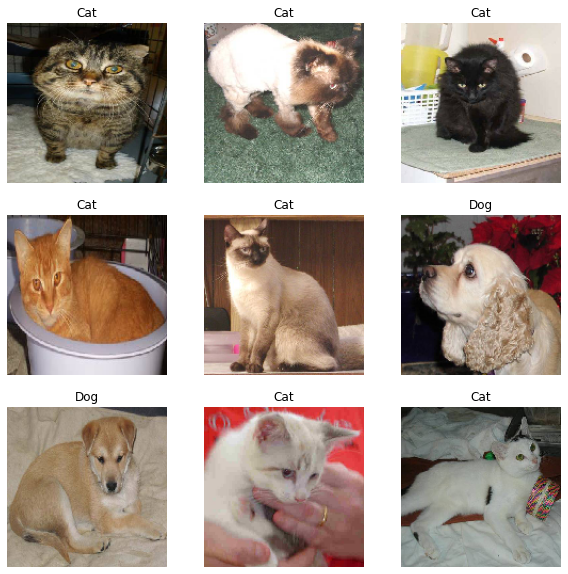

In [7]:
x, y= sample_data.next()
plt.figure(figsize=(10, 10))
for i in range(0,9):
    image = x[i]
    label = 'Cat' if y[i] == 0.0 else 'Dog'
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

## Image Augumentation Example
### Width Shift, Factor 0.4
#### Cat

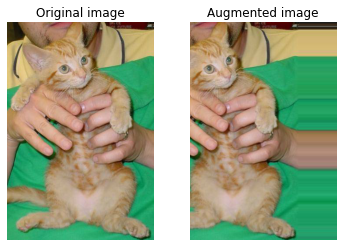

In [9]:
import random
image_gen = ImageDataGenerator(rescale=1./255, width_shift_range=0.4)
catimg = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/cats/cat.'+ str(random.randint(1000, 1009)) +'.jpg') # this is a PIL image
x = img_to_array(catimg) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

y = image_gen.flow(x, batch_size=1)
for i in range(3):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(catimg)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    img = y.next()
    plt.imshow(img[0])
    plt.axis("off")

#### Dog

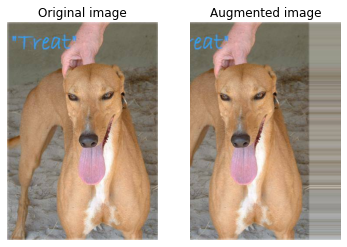

In [10]:
dogimg = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/dogs/dog.'+ str(random.randint(1000, 1009)) +'.jpg') # this is a PIL image
p = img_to_array(dogimg)
p = p.reshape((1,) + p.shape)

q = image_gen.flow(p, batch_size=1)

for i in range(3):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(dogimg)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    img = q.next()
    plt.imshow(img[0])
    plt.axis("off")

## Image Augumentation Example
### Horizontal Flip
#### Cat

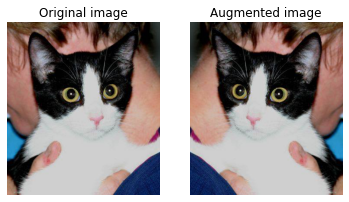

In [11]:
cat_image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
catimg = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/cats/cat.'+ str(random.randint(1000, 1009)) +'.jpg') # this is a PIL image
x = img_to_array(catimg) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

y = cat_image_gen.flow(x, batch_size=1)
for i in range(3):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(catimg)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    img = y.next()
    plt.imshow(img[0])
    plt.axis("off")

#### Dog


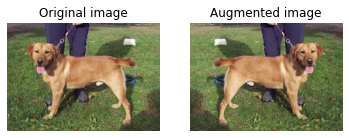

In [12]:
d_image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
dogimg = load_img('/kaggle/input/dogs-cats-images/dataset/training_set/dogs/dog.'+ str(random.randint(1000, 1009)) +'.jpg') # this is a PIL image
x = img_to_array(dogimg) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

w = d_image_gen.flow(x, batch_size=1)
for i in range(3):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(dogimg)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    img = w.next()
    plt.imshow(img[0])
    plt.axis("off")

## Generate Training and Testing Data

In [13]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.4,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        path_to_train,  
        target_size=(150, 150),  
        batch_size=64,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

test_set = test_datagen.flow_from_directory(
        path_to_test, 
        target_size=(150, 150),  
        batch_size=64,
        class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Plot sample training samples after data augumentation

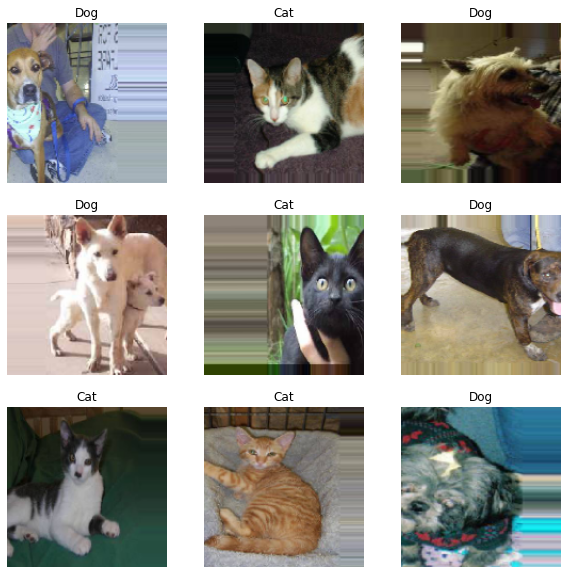

In [14]:
x, y= training_set.next()
plt.figure(figsize=(10, 10))
for i in range(0,9):
    image = x[i]
    label = 'Cat' if y[i] == 0.0 else 'Dog'
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

In [15]:
def plot_graph(history):
  plt.plot(history.history['accuracy'], label='Train Acc')
  plt.plot(history.history['val_accuracy'], label='Val Acc')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Plot of Training & Validation Accuracy')
  plt.legend()
  plt.show()

def plot_model_loss_graph(history):
    # summarize history for loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# ANN Model

In [16]:
# Intialising the CNN
classifier = Sequential()


classifier.add(Conv2D(32, 3, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D())

classifier.add(Conv2D(32, 3, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D())

classifier.add(Conv2D(64, 3, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D())

classifier.add(Conv2D(128, 3, padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D())

classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Train the model

In [17]:
batch_size=64
history = classifier.fit(
        training_set,
        steps_per_epoch=8000 // batch_size,
        epochs=25,
        validation_data=test_set,
        validation_steps=2000 // batch_size)

Epoch 1/25
125/125 [==============================] - 251s 2s/step - loss: 1.3114 - accuracy: 0.5466 - val_loss: 0.7379 - val_accuracy: 0.4980
Epoch 2/25
125/125 [==============================] - 234s 2s/step - loss: 0.6155 - accuracy: 0.6531 - val_loss: 0.7553 - val_accuracy: 0.5005
Epoch 3/25
125/125 [==============================] - 251s 2s/step - loss: 0.6044 - accuracy: 0.6668 - val_loss: 1.7494 - val_accuracy: 0.5171
Epoch 4/25
125/125 [==============================] - 231s 2s/step - loss: 0.5795 - accuracy: 0.6972 - val_loss: 0.7309 - val_accuracy: 0.5948
Epoch 5/25
125/125 [==============================] - 230s 2s/step - loss: 0.5311 - accuracy: 0.7336 - val_loss: 0.4670 - val_accuracy: 0.7777
Epoch 6/25
125/125 [==============================] - 239s 2s/step - loss: 0.4912 - accuracy: 0.7580 - val_loss: 0.9552 - val_accuracy: 0.5796
Epoch 7/25
125/125 [==============================] - 231s 2s/step - loss: 0.4957 - accuracy: 0.7589 - val_loss: 0.4579 - val_accuracy: 0.7959

### Find Mean Training Accuracy And Validation Accuracy

In [18]:
print("Average training accuracy >",np.mean(history.history['accuracy']))
print("Average validation accuracy >",np.mean(history.history['val_accuracy']))

Average training accuracy > 0.8216499924659729
Average validation accuracy > 0.7771975803375244


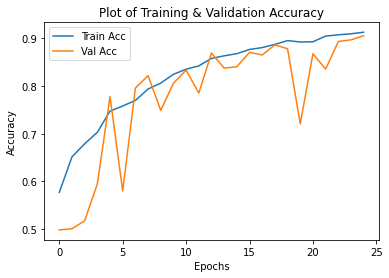

In [19]:
plot_graph(history)

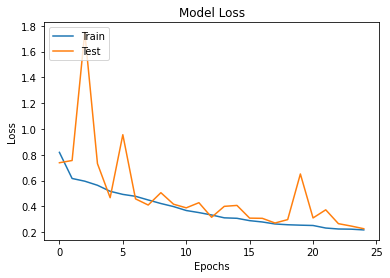

In [20]:
plot_model_loss_graph(history)

### Find final testing accuracy

In [24]:
# Evaluate model
_, acc = classifier.evaluate(test_set, steps=len(test_set), verbose=1)
print('Final Testing Accuracy With The Test Data > %.3f' % (acc * 100.0))

32/32 [==============================] - 16s 487ms/step - loss: 0.2273 - accuracy: 0.9050
Final Testing Accuracy With The Test Data > 90.500


# Predicted values

In [28]:
Y_pred = classifier.predict(test_set, 2000 // batch_size+1)
print(Y_pred.shape)

(2000, 1)
